In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import models
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D

%matplotlib inline
plt.style.use("seaborn")

Merge both input datasets into one containing only relevant columns

In [2]:
first = pd.read_csv("../input/amazon-cell-phones-reviews/20190928-reviews.csv")
first["review"] = first["title"] + " " +  first["body"]
first = first[["review", "rating"]]
second = pd.read_csv("../input/amazon-reviews-unlocked-mobile-phones/Amazon_Unlocked_Mobile.csv")
second = second[["Reviews", "Rating"]]
data = pd.DataFrame(np.concatenate([first.values, second.values]), columns=first.columns)
data = data.dropna()

Plot all ratings in barplot

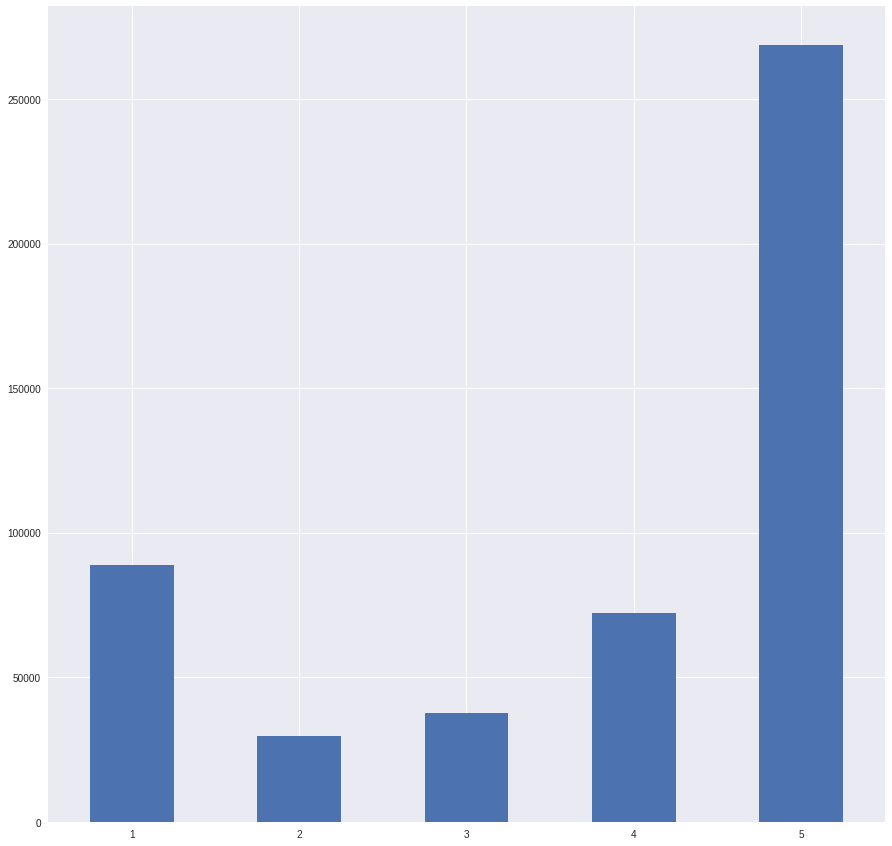

In [3]:
data.rating.value_counts().reindex([1, 2, 3, 4, 5]).plot.bar(rot=0, y='rating', figsize=(15, 15))

Remove neutral reviews (rating=3) and mark rest as negative/positive (0/1)

Also remove overly long reviews (len >= 2000)

In [4]:
data["rating"] = data["rating"].astype("int")
data = data[data.rating != 3]
data["rating"] = data.rating.apply(lambda x: 0 if x < 3 else 1)
data = data[data.review.str.len() < 2000]

Collect metrics from final data

Total samples:  454081
Positive:  336707
Negative:  117374
Median number of words in review:  18.0


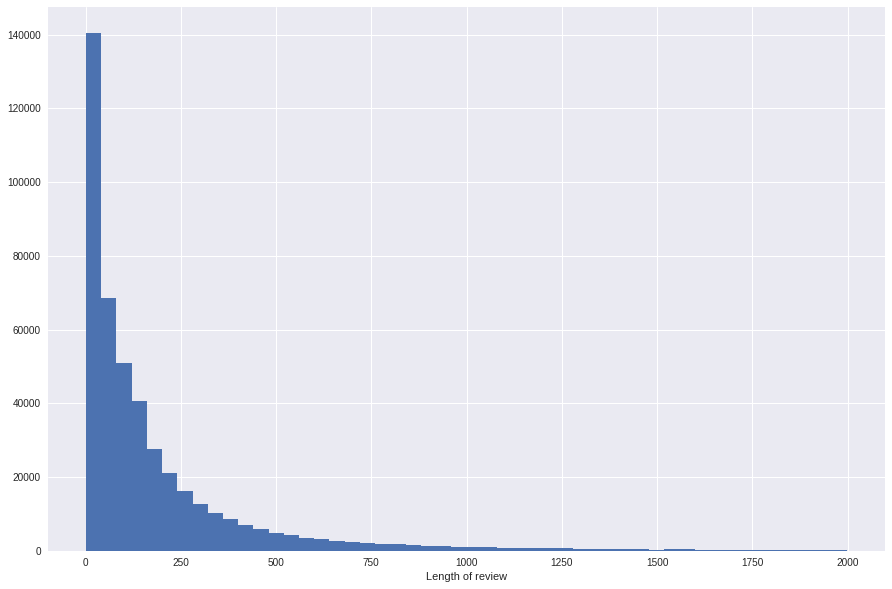

In [5]:
print("Total samples: ", data.review.count())
print("Positive: ", data.rating.value_counts()[1])
print("Negative: ", data.rating.value_counts()[0])
median_words = np.median([len(s.split()) for s in data.review])
print("Median number of words in review: ", median_words)
plt.figure(figsize=(15, 10))
plt.hist([len(s) for s in data.review], bins=50)
plt.xlabel('Length of review')
#plt.title('Review length distribution up to 2000')
plt.show()

Generate seperate wordclouds for positive/negative reviews

In [6]:
def tokenize(texts):
    tokenizer = text.Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(texts)
    return tokenizer

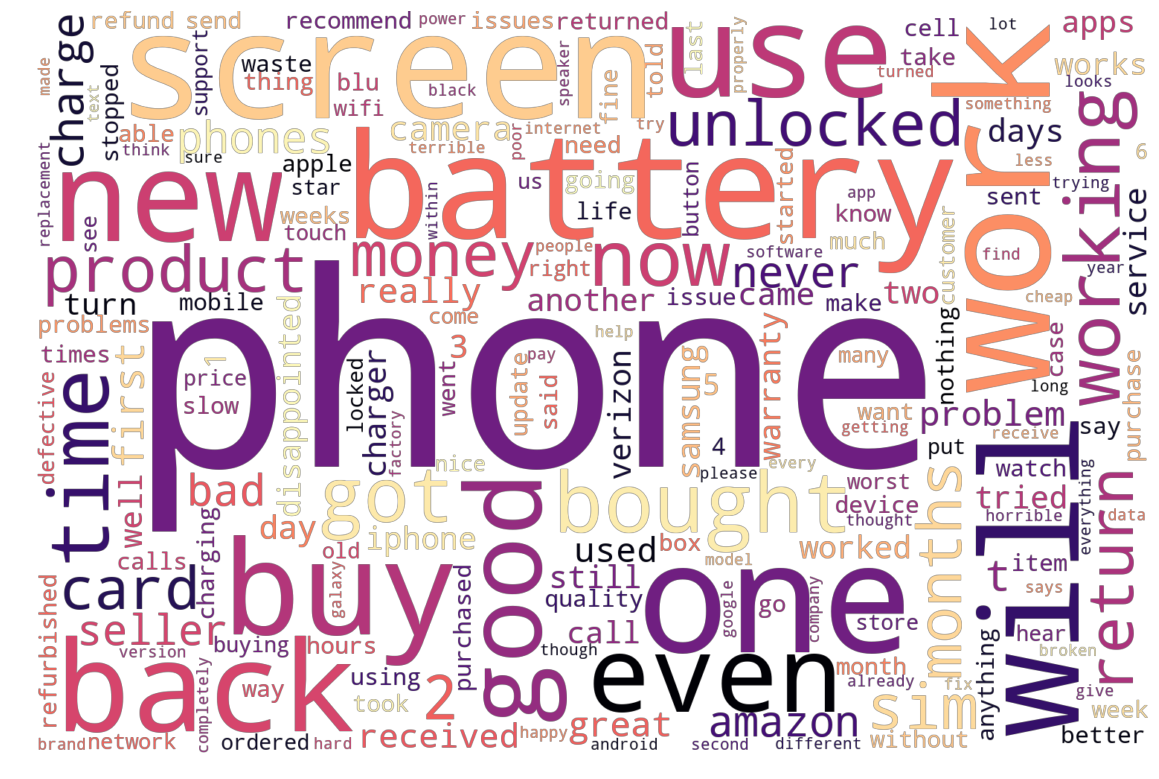

In [7]:
wordcloud = WordCloud(height=1000, width=1500, mode="RGBA", background_color=None, colormap='magma', random_state=420)
# Remove stopwords manually
negative = wordcloud.generate_from_frequencies({word: count for (word, count) in tokenize(data[data.rating == 0].review).word_counts.items() if word not in STOPWORDS})
plt.figure(figsize=(20, 30))
plt.imshow(negative, interpolation="bilinear")
plt.axis("off")
plt.show()

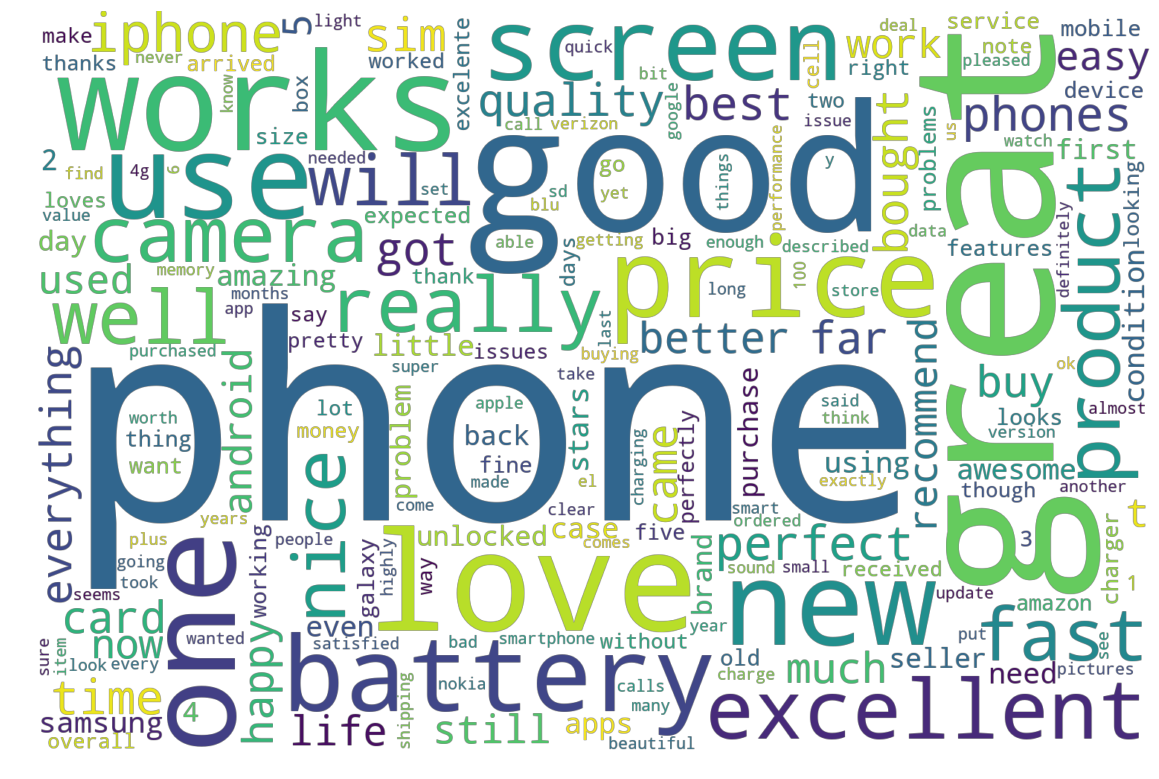

In [8]:
wordcloud = WordCloud(height=1000, width=1500, mode="RGBA", background_color=None, random_state=420)
# Remove stopwords manually
positive = wordcloud.generate_from_frequencies({word: count for (word, count) in tokenize(data[data.rating == 1].review).word_counts.items() if word not in STOPWORDS})
plt.figure(figsize=(20, 30))
plt.imshow(positive, interpolation="bilinear")
plt.axis("off")
plt.show()

Downsample positive samples, split into train/test

In [9]:
balanced = pd.concat([data[data.rating == 0], resample(data[data.rating == 1], replace=False, n_samples=117374, random_state=42)])
balanced.rating.value_counts()
train, test = train_test_split(balanced, stratify=balanced.rating, random_state=42)
train_text, train_label, test_text, test_label = train.review, np.asarray(train.rating), test.review, np.asarray(test.rating)
train.rating.value_counts()

1    88031
0    88030
Name: rating, dtype: int64

Function to tokenize and vectorize text, [source](https://github.com/google/eng-edu/tree/master/ml/guides/text_classification)

In [10]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = tokenize(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    # Since our median review length was only 18 words, maximum length of 200 should be more than enough
    max_length = len(max(x_train, key=len))
    if max_length > 200:
        max_length = 200

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

Create and train CNN model, [source](https://github.com/google/eng-edu/tree/master/ml/guides/text_classification)

In [11]:
def train_sequence_model(train_data,
                         learning_rate=1e-3,
                         epochs=3,
                         batch_size=128,
                         filters=64,
                         dropout_rate=0.25,
                         embedding_dim=250,
                         kernel_size=5):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = train_data

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, 20000)

    # Create model instance.
    
    model = models.Sequential()
    model.add(Embedding(input_dim=num_features,
                        output_dim=embedding_dim,
                        input_length=x_train.shape[1:][0]))
    model.add(Dropout(rate=dropout_rate))
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     strides=1,
                     activation='relu',
                     padding='valid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])


    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            validation_data=(x_val, val_labels),
            verbose=2, 
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('amazon_reviews_cnn_model.h5')
    return history

In [12]:
history = train_sequence_model(train_data=((train_text, train_label), (test_text, test_label)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 250)          5000000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 250)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           80064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 5,080,129
Trainable params: 5,080,129
Non-trainable params: 0
_________________________________________________________________
Train on 176061 samples, validate on 58687 samples
Epoch 1/3
176061/176061 - 118s - loss: 0.1794 - acc: 0.9319 -

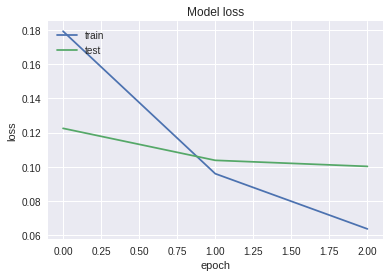

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

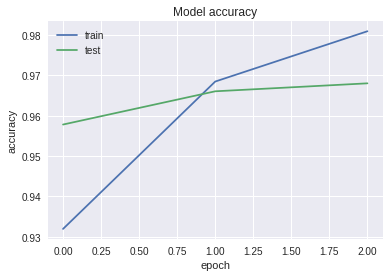

In [14]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()